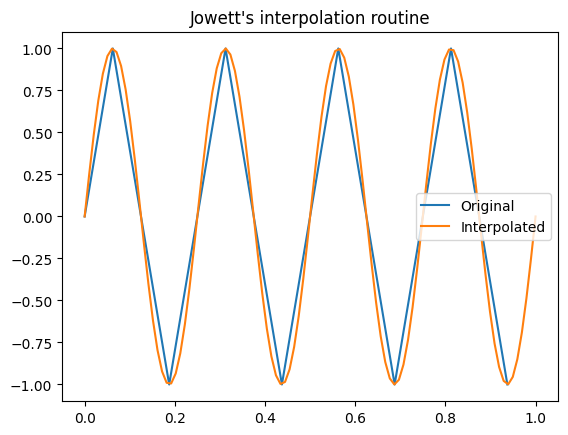

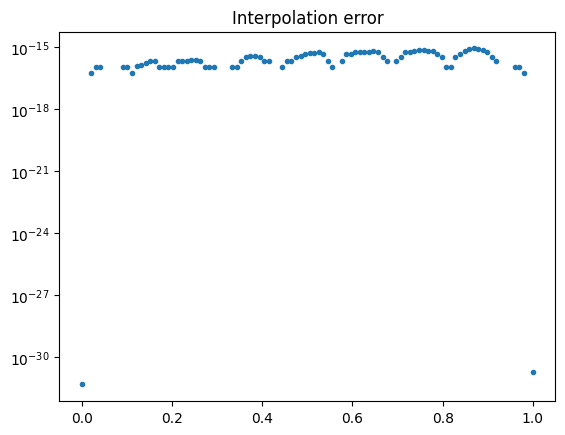

In [4]:


import numpy as np

import matplotlib.pyplot as plt

# Define the periodic function (in this case, a sine wave)

def f(x):
    return np.sin(8*np.pi*x)



def fft_interp(coeffs, x):
    # 1D FFT interpolate for arbitrary x
    # assume x is periodic on [0,1] interval
    size = len(coeffs)
    kn = np.fft.fftfreq(size)
    eikx = np.sin(2.j*np.pi*x*size*kn)

    return np.dot(coeffs, eikx) / size





# Define the range of x values over which the function is defined
xmin = 0
xmax = 1.

# Define the number of points used to sample the function
n_points = 16

# Generate the x values at which to sample the function
x = np.linspace(xmin, xmax, n_points, endpoint=False)
dx = x[1]-x[0]

# Evaluate the function at the sample points
y = f(x)

# Compute the FFT of the function
fft_y = np.fft.fft(y)

xx = np.linspace(0,1,100)
interp = []
for xxx in xx:
    interp.append(np.real(fft_interp(fft_y,xxx)))


# Print the interpolated value
#print("Interpolated value at x=1.5:", np.real(interp_val))

# Print the interpolated value
plt.title("Jowett's interpolation routine")
plt.plot(x,f(x),'-', label="Original")
plt.plot(xx, interp, label="Interpolated")
plt.legend()
plt.show()

plt.title("Interpolation error")
#plt.plot(x[0]+dx*interp_index,interp_val,'.')
plt.yscale("log")
plt.plot(xx, np.abs(interp-f(xx)),'.')
plt.show()

64


/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


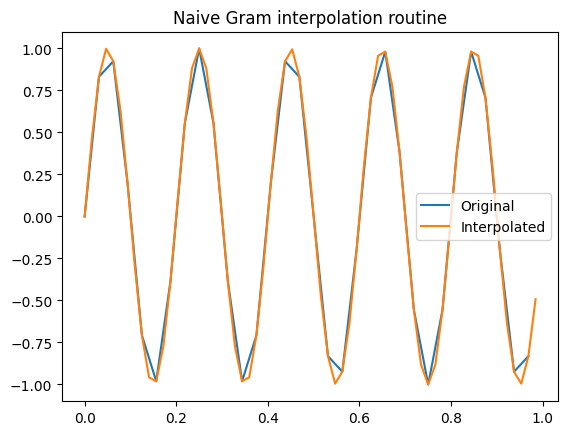

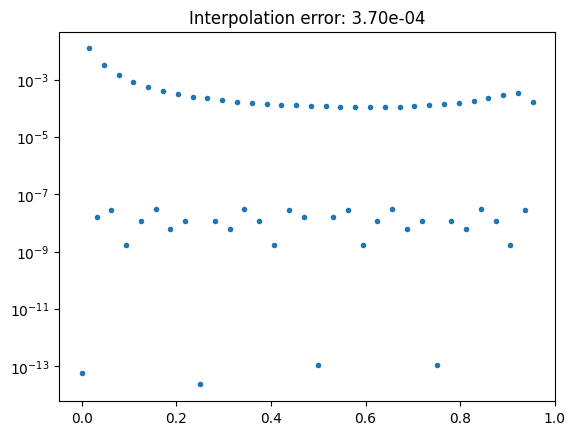

[0.       0.015625 0.03125  0.046875 0.0625   0.078125 0.09375  0.109375
 0.125    0.140625 0.15625  0.171875 0.1875   0.203125 0.21875  0.234375
 0.25     0.265625 0.28125  0.296875 0.3125   0.328125 0.34375  0.359375
 0.375    0.390625 0.40625  0.421875 0.4375   0.453125 0.46875  0.484375
 0.5      0.515625 0.53125  0.546875 0.5625   0.578125 0.59375  0.609375
 0.625    0.640625 0.65625  0.671875 0.6875   0.703125 0.71875  0.734375
 0.75     0.765625 0.78125  0.796875 0.8125   0.828125 0.84375  0.859375
 0.875    0.890625 0.90625  0.921875 0.9375   0.953125 0.96875  0.984375]


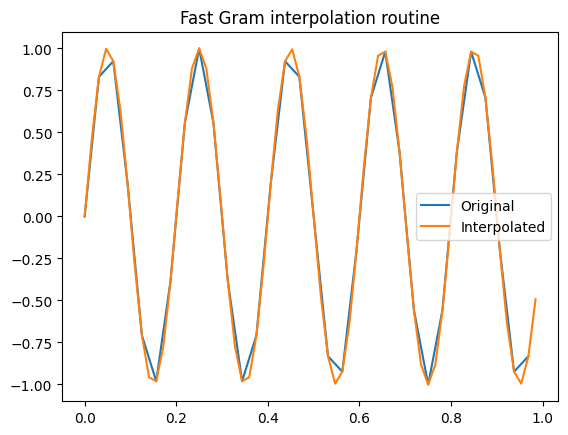

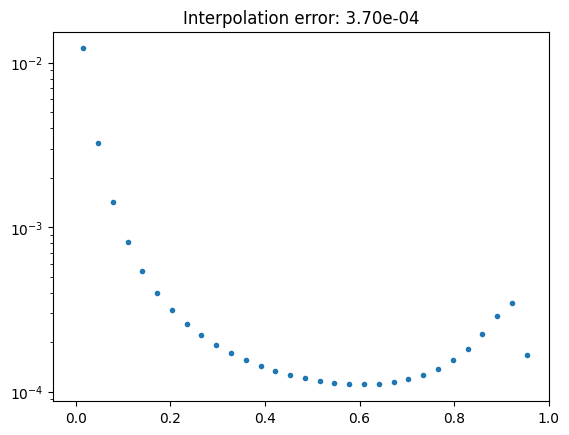

In [5]:
import scipy
import spectral_derivative as sd 

class GramInterpolation: 
    def __init__(self, config):
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal      = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput     = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 

        self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Fe = self.F[:nD, :].astype(self.mreal) 
        self.Fo = self.F[nD:, :].astype(self.mreal) 
        self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal) 
        self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal) 


    def simpleInterpolation(self, input):
        psi = input.astype(self.minput) 
        nDelta = self.nDelta
        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 

        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([f, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)

        fhat = scipy.fft.fft(fdp[:-2], norm="forward").astype(self.mcomplex) 
        

        N = len(fhat) 
        Ni = 2 * N 
        Npad = int(Ni/2 - N/2) 
        ft   = np.fft.fftshift(fhat)
        ft_pad = np.concatenate([np.zeros(Npad), ft, np.zeros(Npad)])
        fint = scipy.fft.ifft(np.fft.fftshift(ft_pad), norm="forward")[:len(input)*2].astype(np.csingle)
        return fint
    
    def fastInterpolation(self, input):
        psi = input.astype(self.minput) 
        nDelta = self.nDelta
        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 

        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([f, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)

        fhat = scipy.fft.fft(fdp[:-2]).astype(self.mcomplex) 
        

        k = sd.computeK(fhat, 1, sd.PERIODIC).astype(self.mcomplex) 

        fhat *= np.exp(1j * k/2)

        fint = scipy.fft.ifft(fhat)[:len(input)].astype(np.csingle)
        return np.stack((f, fint)).transpose().flatten()

        
c = {}
c["extensionGamma"]             = 150
c["extensionG"]                 = 63
c["extensionNDelta"]            = 6
c["extensionND"]                = 28
c["realPrecision"]              = np.double
c["complexPrecision"]           = np.cdouble
c["inputPrecision"]             = np.double
        
gint = GramInterpolation(c) 


def f(x):
    return np.sin(10*np.pi*x)#np.sin(2*np.pi* x)
# Define the range of x values over which the function is defined
xmin = 0
xmax = 1.

# Define the number of points used to sample the function
n_points = 32


# Generate the x values at which to sample the function
x = np.linspace(xmin, xmax, n_points + 1)[:-1]
dx = x[1]-x[0]

xx = np.linspace(xmin, xmax, 2*n_points + 1)[:-1]

# Evaluate the function at the sample points
y = f(x)

yint = gint.simpleInterpolation(y)
print(len(yint))

plt.title("Naive Gram interpolation routine")
plt.plot(x, y,'-', label="Original")
plt.plot(xx, yint, label="Interpolated")
plt.legend()
plt.show()

plt.title(f"Interpolation error: {np.mean(np.abs(yint-f(xx))[:-2]):2.2e}")
#plt.plot(x[0]+dx*interp_index,interp_val,'.')
plt.yscale("log")
plt.plot(xx[:-2], np.abs(yint-f(xx))[:-2],'.')
plt.show()


yint = gint.fastInterpolation(y)
print(xx)


plt.title("Fast Gram interpolation routine")
plt.plot(x, y,'-', label="Original")
plt.plot(xx, yint, label="Interpolated")
plt.legend()
plt.show()

plt.title(f"Interpolation error: {np.mean(np.abs(yint-f(xx))[:-2]):2.2e}")
#plt.plot(x[0]+dx*interp_index,interp_val,'.')
plt.yscale("log")
plt.plot(xx[:-2], np.abs(yint-f(xx))[:-2],'.')
plt.show()

In [36]:

from scipy.linalg import lu, inv




class IPRInterpolation:
    def __init__(self, N):
        self.lam = 0.5
        self.grid = np.linspace(0, 1, N) 
        print(self.shiftx(self.grid))
        self.W   = self.directW(self.shiftx(self.grid), int(len(self.grid)/2), self.lam)
    
    def interpolate(self, input): 
        #Aliases
        N           = len(input)
        x           = np.linspace(0, 1, 2 * N)
        psi         = input.astype(np.csingle).astype(np.cdouble)
        
        fhat        = scipy.fft.fft(psi)
        print("FFT of input vector x: ", fhat)
        print("f shape: ", fhat.shape) 
        print("W shape: ", self.W.shape)
        g           = self.gaussWithTruncation(self.W, fhat)
        print("The coefficients: ", g)
        yint        = self.reconstruct(g, self.lam, self.shiftx(x))
        return yint  

    def C(self, x, lam, N): 
        return scipy.special.eval_gegenbauer(N,lam, x)

    #Construct matrices T and V recursively for arbitrary lambda
    def directW(self, x, N, lam): 
        # Even 
        W = np.zeros((2*N, 2*N), dtype=complex)
        
        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.C(x, lam, l))

        return W 

    def reconstruct(self, g, lam, x): 
        n = len(x)
        f = np.zeros(x.shape, dtype=complex)
        for l, coeff in enumerate(g):
            f += coeff * self.C(x, lam, l)

        return f

    def shiftx(self, x):
        dx = x[1] - x[0]
        a  = x[0]
        b  = x[-1] + dx
        return  (x - (a + b)/2)/ ((b - a)/2)
    
    def gaussWithTruncation(self, A,B):
        """
        Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
        """
        # LU decomposition with pivot
        p, l, u = lu(A, permute_l=False)
        
        # forward substitution to solve for Ly = B
        y = np.zeros(B.size, dtype=np.csingle)
        for m, b in enumerate((p.T @ B).flatten()):
            y[m] = b
            # skip for loop if m == 0
            if m:
                for n in range(m):
                    y[m] -= y[n] * l[m,n]
            y[m] /= l[m, m]

        # truncation for IPR
        c = np.abs(y) < 1000 * np.finfo(np.single).eps
        y[c] = 0

        # backward substitution to solve for y = Ux
        x = np.zeros(B.size, dtype=np.csingle)
        lastidx = B.size - 1  # last index
        for midx in range(B.size):
            m = B.size - 1 - midx  # backwards index
            x[m] = y[m]
            if midx:
                for nidx in range(midx):
                    n = B.size - 1  - nidx
                    x[m] -= x[n] * u[m,n]
            x[m] /= u[m, m]
        return x


[-1.   -0.96 -0.92 -0.88 -0.84 -0.8  -0.76 -0.72 -0.68 -0.64 -0.6  -0.56
 -0.52 -0.48 -0.44 -0.4  -0.36 -0.32 -0.28 -0.24 -0.2  -0.16 -0.12 -0.08
 -0.04  0.    0.04  0.08  0.12  0.16  0.2   0.24  0.28  0.32  0.36  0.4
  0.44  0.48  0.52  0.56  0.6   0.64  0.68  0.72  0.76  0.8   0.84  0.88
  0.92  0.96]
FFT of input vector x:  [-0.91294527+0.00000000e+00j -0.91294527-3.87336837e-01j
 -0.91294527-8.35086094e-01j -0.91294527-1.44196125e+00j
 -0.91294527-2.44885750e+00j -0.91294527-4.77797503e+00j
 -0.91294527-1.93712609e+01j -0.91294527+1.18657916e+01j
 -0.91294527+4.79130759e+00j -0.91294527+3.04899947e+00j
 -0.91294527+2.23958118e+00j -0.91294527+1.76071023e+00j
 -0.91294527+1.43732525e+00j -0.91294527+1.19966696e+00j
 -0.91294527+1.01434978e+00j -0.91294527+8.63321048e-01j
 -0.91294527+7.35917804e-01j -0.91294527+6.25398954e-01j
 -0.91294527+5.27262045e-01j -0.91294527+4.38356576e-01j
 -0.91294527+3.56383857e-01j -0.91294527+2.79600201e-01j
 -0.91294527+2.06628348e-01j -0.91294527+1.3

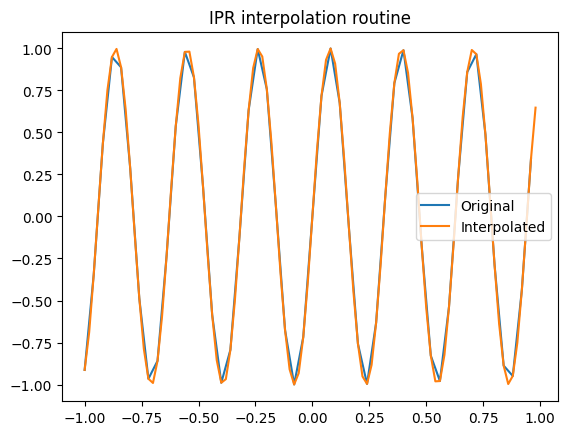

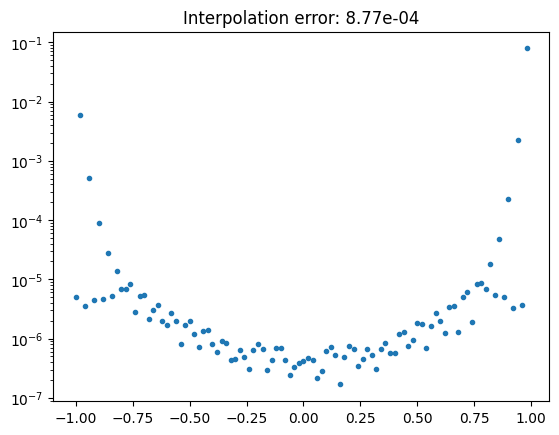

In [37]:

# Define the number of points used to sample the function
n_points = 50

gint = IPRInterpolation(n_points) 

def f(x):
    return np.sin(20*x)

# Define the range of x values over which the function is defined
xmin = 0
xmax = 1


# Generate the x values at which to sample the function
x = np.linspace(-1, 1, n_points + 1)[:-1]
dx = x[1]-x[0]

xx = np.linspace(-1, 1, 2*n_points + 1)[:-1]

# Evaluate the function at the sample points
y = f(x)

yint = gint.interpolate(y)

print(len(yint))

plt.title("IPR interpolation routine")
plt.plot(x, y,'-', label="Original")
plt.plot(xx, yint, label="Interpolated")
plt.legend()
plt.show()

plt.title(f"Interpolation error: {np.mean(np.abs(yint-f(xx))):2.2e}")
#plt.plot(x[0]+dx*interp_index,interp_val,'.')
plt.yscale("log")
plt.plot(xx, np.abs(yint-f(xx)),'.')
plt.show()


In [12]:

print(gint.shiftx(gint.grid))

[-1.        -0.9921875 -0.984375  -0.9765625 -0.96875   -0.9609375
 -0.953125  -0.9453125 -0.9375    -0.9296875 -0.921875  -0.9140625
 -0.90625   -0.8984375 -0.890625  -0.8828125 -0.875     -0.8671875
 -0.859375  -0.8515625 -0.84375   -0.8359375 -0.828125  -0.8203125
 -0.8125    -0.8046875 -0.796875  -0.7890625 -0.78125   -0.7734375
 -0.765625  -0.7578125 -0.75      -0.7421875 -0.734375  -0.7265625
 -0.71875   -0.7109375 -0.703125  -0.6953125 -0.6875    -0.6796875
 -0.671875  -0.6640625 -0.65625   -0.6484375 -0.640625  -0.6328125
 -0.625     -0.6171875 -0.609375  -0.6015625 -0.59375   -0.5859375
 -0.578125  -0.5703125 -0.5625    -0.5546875 -0.546875  -0.5390625
 -0.53125   -0.5234375 -0.515625  -0.5078125 -0.5       -0.4921875
 -0.484375  -0.4765625 -0.46875   -0.4609375 -0.453125  -0.4453125
 -0.4375    -0.4296875 -0.421875  -0.4140625 -0.40625   -0.3984375
 -0.390625  -0.3828125 -0.375     -0.3671875 -0.359375  -0.3515625
 -0.34375   -0.3359375 -0.328125  -0.3203125 -0.3125    -0.304

In [36]:

A = np.array([2.0, 2.0, -1.0, 3.0, 1.0, 1.0, 2.0, -1.0, 2.0]).reshape(3, 3)
b = np.array([3.0, 8.0, 5.0])

def gaussWithTruncation(A,B):
        """
        Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
        """
        # LU decomposition with pivot
        p, l, u = lu(A, permute_l=False)
        
        # forward substitution to solve for Ly = B
        y = np.zeros(B.size, dtype=np.csingle)
        print("Perm B: ", p.T @ B)
        for m, b in enumerate((p.T @ B).flatten()):
            y[m] = b
            # skip for loop if m == 0
            if m:
                for n in range(m):
                    y[m] -= y[n] * l[m,n]
            print(l[m, m])
            y[m] /= l[m, m]

        print("After forward substitution: ", y)

        # truncation for IPR
        #c = np.abs(y) < 1000 * np.finfo(np.single).eps
        #y[c] = 0

        # backward substitution to solve for y = Ux
        x = np.zeros(B.size, dtype=np.csingle)
        lastidx = B.size - 1  # last index
        for midx in range(B.size):
            m = B.size - 1 - midx  # backwards index
            x[m] = y[m]
            if midx:
                for nidx in range(midx):
                    n = B.size - 1  - nidx
                    x[m] -= x[n] * u[m,n]
            x[m] /= u[m, m]
        return x

In [37]:
gaussWithTruncation(A, b)

Perm B:  [8. 5. 3.]
1.0
1.0
1.0
After forward substitution:  [ 8.        +0.j -0.33333334+0.j -2.6       +0.j]


array([1.5894572e-07+0.j, 3.6666665e+00-0.j, 4.3333330e+00-0.j],
      dtype=complex64)

In [38]:
np.linalg.solve(A, b)

array([-1.48029737e-15,  3.66666667e+00,  4.33333333e+00])

In [39]:
np.linalg.det(A)

2.9999999999999982

In [33]:
def directW(x, N, lam): 
    # Even 
    W = np.zeros((2*N, 2*N), dtype=complex)
    
    for l in range(2*N):
        input = scipy.special.eval_gegenbauer(l, lam, x)
        print("l = ", l, " ", input) 
        W[:, l] = scipy.fft.fft(input)

    return W 

In [55]:
scipy.special.eval_gegenbauer(2, 0.5, 0.3)

-0.36499999999999994

In [39]:
x = np.linspace(0, 1, 8) 
gint.shiftx(x)

array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75])

In [43]:
mat = directW(gint.shiftx(x), 4, 1)

l =  0   [1. 1. 1. 1. 1. 1. 1. 1.]
l =  1   [-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5]
l =  2   [ 3.    1.25  0.   -0.75 -1.   -0.75  0.    1.25]
l =  3   [-4.    -0.375  1.     0.875  0.    -0.875 -1.     0.375]
l =  4   [ 5.     -0.6875 -1.      0.3125  1.      0.3125 -1.     -0.6875]
l =  5   [-6.00000000e+00  1.40625000e+00  6.66133815e-16 -1.03125000e+00
  0.00000000e+00  1.03125000e+00  1.66533454e-16 -1.40625000e+00]
l =  6   [ 7.       -1.421875  1.        0.203125 -1.        0.203125  1.
 -1.421875]
l =  7   [-8.         0.7265625 -1.         0.9296875  0.        -0.9296875
  1.        -0.7265625]


In [49]:
n, m = mat.shape
for i in range(n):
    for j in range(m): 
        print(f"{mat[i, j]:2.5f}", " ", end ="") 
    print("")

8.00000-0.00000j  -2.00000-0.00000j  3.00000-0.00000j  -4.00000-0.00000j  3.25000-0.00000j  -6.00000-0.00000j  5.56250-0.00000j  -8.00000-0.00000j  
0.00000+0.00000j  -2.00000+4.82843j  6.82843+0.00000j  -4.00000-2.70711j  2.58579+0.00000j  -6.00000-0.53033j  5.70190+0.00000j  -8.00000-0.34229j  
0.00000-0.00000j  -2.00000+2.00000j  2.00000+0.00000j  -4.00000+2.50000j  8.00000+0.00000j  -6.00000-4.87500j  4.00000-0.00000j  -8.00000+0.40625j  
0.00000+0.00000j  -2.00000+0.82843j  1.17157+0.00000j  -4.00000+1.29289j  5.41421+0.00000j  -6.00000-0.53033j  10.29810-0.00000j  -8.00000-4.34229j  
0.00000-0.00000j  -2.00000-0.00000j  1.00000-0.00000j  -4.00000-0.00000j  4.75000-0.00000j  -6.00000-0.00000j  10.43750-0.00000j  -8.00000-0.00000j  
0.00000-0.00000j  -2.00000-0.82843j  1.17157-0.00000j  -4.00000-1.29289j  5.41421-0.00000j  -6.00000+0.53033j  10.29810+0.00000j  -8.00000+4.34229j  
0.00000+0.00000j  -2.00000-2.00000j  2.00000-0.00000j  -4.00000-2.50000j  8.00000-0.00000j  -6.00000+4.

8.00000 + 0.00000i -2.00000 + 0.00000i 3.00000 + 0.00000i -4.00000 + 0.00000i 3.25000 + 0.00000i -6.00000 + 0.00000i 5.56250 + 0.00000i -8.00000 + 0.00000i 
0.00000 + 0.00000i -2.00000 + 4.82843i 6.82843 + 0.00000i -4.00000 + -2.70711i 2.58579 + 0.00000i -6.00000 + -0.53033i 5.70190 + 0.00000i -8.00000 + -0.34229i 
0.00000 + 0.00000i -2.00000 + 2.00000i 2.00000 + 0.00000i -4.00000 + 2.50000i 8.00000 + 0.00000i -6.00000 + -4.87500i 4.00000 + 0.00000i -8.00000 + 0.40625i 
0.00000 + 0.00000i -2.00000 + 0.82843i 1.17157 + 0.00000i -4.00000 + 1.29289i 5.41421 + 0.00000i -6.00000 + -0.53033i 10.29810 + 0.00000i -8.00000 + -4.34229i 
0.00000 + 0.00000i -2.00000 + 0.00000i 1.00000 + 0.00000i -4.00000 + 0.00000i 4.75000 + 0.00000i -6.00000 + 0.00000i 10.43750 + 0.00000i -8.00000 + 0.00000i 
0.00000 + -0.00000i -2.00000 + -0.82843i 1.17157 + -0.00000i -4.00000 + -1.29289i 5.41421 + -0.00000i -6.00000 + 0.53033i 10.29810 + -0.00000i -8.00000 + 4.34229i 
0.00000 + -0.00000i -2.00000 + -2.00000i 2.00000 + -0.00000i -4.00000 + -2.50000i 8.00000 + -0.00000i -6.00000 + 4.87500i 4.00000 + -0.00000i -8.00000 + -0.40625i 
0.00000 + -0.00000i -2.00000 + -4.82843i 6.82843 + -0.00000i -4.00000 + 2.70711i 2.58579 + -0.00000i -6.00000 + 0.53033i 5.70190 + -0.00000i -8.00000 + 0.34229i 

directW(gint.shiftx(x), 4, 1)

In [3]:
A = np.array([1+2j, 3+4j, 5+6j, 7+8j]).reshape(2, 2) 
b = np.array([1+2j, 1+2j])
np.linalg.solve(A, b)

array([-0.75-0.25j,  0.75+0.25j])

In [23]:
A = np.random.random((4, 4)) + np.random.random((4, 4)) *1j
b = np.random.random((4)) + np.random.random((4)) *1j

In [27]:
A.flatten()
b.flatten()

array([0.35949866+0.50397659j, 0.54723742+0.2272631j ,
       0.63002761+0.0078064j , 0.70775683+0.83585604j])

In [25]:
np.linalg.solve(A, b)

array([0.0282586 -0.48352117j, 0.41867725+0.13367337j,
       0.16622679-0.73116745j, 0.36938232+0.70554624j])

64


/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


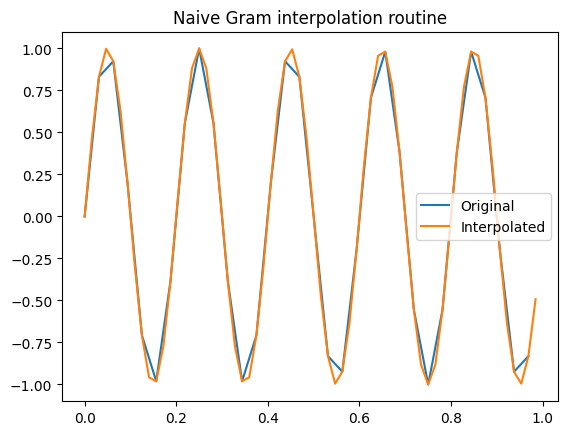

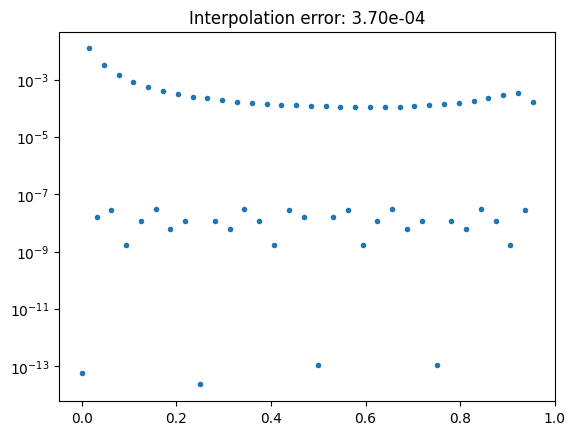

[0.       0.015625 0.03125  0.046875 0.0625   0.078125 0.09375  0.109375
 0.125    0.140625 0.15625  0.171875 0.1875   0.203125 0.21875  0.234375
 0.25     0.265625 0.28125  0.296875 0.3125   0.328125 0.34375  0.359375
 0.375    0.390625 0.40625  0.421875 0.4375   0.453125 0.46875  0.484375
 0.5      0.515625 0.53125  0.546875 0.5625   0.578125 0.59375  0.609375
 0.625    0.640625 0.65625  0.671875 0.6875   0.703125 0.71875  0.734375
 0.75     0.765625 0.78125  0.796875 0.8125   0.828125 0.84375  0.859375
 0.875    0.890625 0.90625  0.921875 0.9375   0.953125 0.96875  0.984375]


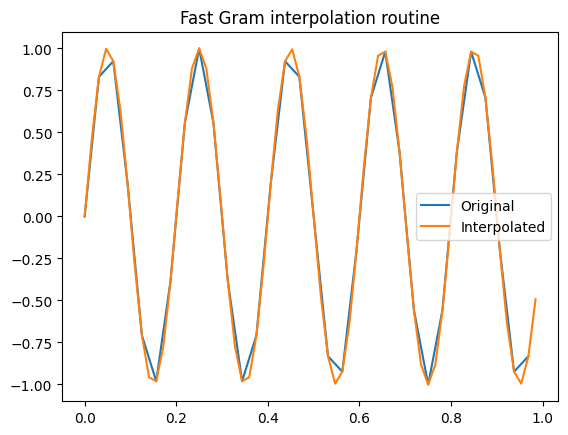

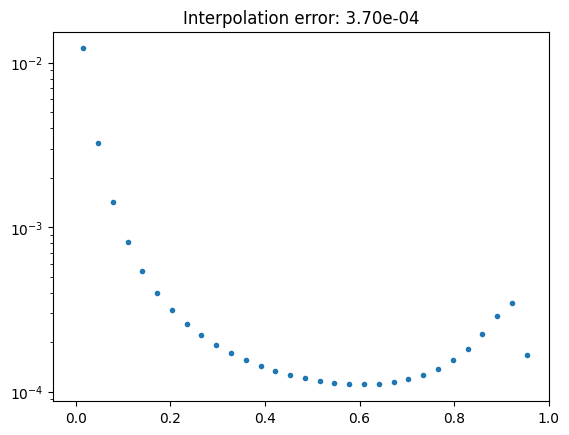

In [2]:
import scipy
import spectral_derivative as sd 
import numpy as np
import matplotlib.pyplot as plt

class GramInterpolation: 
    def __init__(self, config):
        self.Gamma      = config["extensionGamma"]
        self.g          = config["extensionG"]
        self.nDelta     = config["extensionNDelta"]
        self.nd         = config["extensionND"]
        self.mreal      = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput     = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 

        self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Fe = self.F[:nD, :]
        self.Fo = self.F[nD:, :]
        self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD)
        self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD)


    def simpleInterpolation(self, input):
        psi = input.astype(self.minput) 
        nDelta = self.nDelta
        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 

        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([f, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)

        fhat = scipy.fft.fft(fdp[:-2], norm="forward").astype(self.mcomplex) 
        

        N = len(fhat) 
        Ni = 2 * N 
        Npad = int(Ni/2 - N/2) 
        ft   = np.fft.fftshift(fhat)
        ft_pad = np.concatenate([np.zeros(Npad), ft, np.zeros(Npad)])
        fint = scipy.fft.ifft(np.fft.fftshift(ft_pad), norm="forward")[:len(input)*2].astype(np.csingle)
        return fint
    
    def fastInterpolation(self, input):
        psi = input.astype(self.minput) 
        nDelta = self.nDelta
        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 

        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([f, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)

        fhat = scipy.fft.fft(fdp[:-2]).astype(self.mcomplex) 
        

        k = sd.computeK(fhat, 1, sd.PERIODIC).astype(self.mcomplex) 

        fhat *= np.exp(1j * k/2)

        fint = scipy.fft.ifft(fhat)[:len(input)].astype(np.csingle)
        return np.stack((f, fint)).transpose().flatten()

        
c = {}
c["extensionGamma"]             = 150
c["extensionG"]                 = 63
c["extensionNDelta"]            = 6
c["extensionND"]                = 28
c["realPrecision"]              = np.double
c["complexPrecision"]           = np.cdouble
c["inputPrecision"]             = np.double
        
gint = GramInterpolation(c) 


def f(x):
    return np.sin(10*np.pi*x)#np.sin(2*np.pi* x)
# Define the range of x values over which the function is defined
xmin = 0
xmax = 1.

# Define the number of points used to sample the function
n_points = 32


# Generate the x values at which to sample the function
x = np.linspace(xmin, xmax, n_points + 1)[:-1]
dx = x[1]-x[0]

xx = np.linspace(xmin, xmax, 2*n_points + 1)[:-1]

# Evaluate the function at the sample points
y = f(x)

yint = gint.simpleInterpolation(y)
print(len(yint))

plt.title("Naive Gram interpolation routine")
plt.plot(x, y,'-', label="Original")
plt.plot(xx, yint, label="Interpolated")
plt.legend()
plt.show()

plt.title(f"Interpolation error: {np.mean(np.abs(yint-f(xx))[:-2]):2.2e}")
#plt.plot(x[0]+dx*interp_index,interp_val,'.')
plt.yscale("log")
plt.plot(xx[:-2], np.abs(yint-f(xx))[:-2],'.')
plt.show()


yint = gint.fastInterpolation(y)
print(xx)


plt.title("Fast Gram interpolation routine")
plt.plot(x, y,'-', label="Original")
plt.plot(xx, yint, label="Interpolated")
plt.legend()
plt.show()

plt.title(f"Interpolation error: {np.mean(np.abs(yint-f(xx))[:-2]):2.2e}")
#plt.plot(x[0]+dx*interp_index,interp_val,'.')
plt.yscale("log")
plt.plot(xx[:-2], np.abs(yint-f(xx))[:-2],'.')
plt.show()

In [27]:
Gamma, g, nD, nd = 150, 63, 12, 28


for nd in [19, 21, 23, 25, 27, 29, 31, 33, 35, 37]: 
    for m in [6, 8, 10, 12, 14]: 
        nD = m
        F  = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        Fe = F[:nD, nD:nD + nd - 2]
        Fo = F[nD:, nD:nD + nd - 2]
        Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD)
        Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD)
        Pb = np.block([[Pl, np.zeros((nD, nD))], [np.zeros((nD, nD)), Pr]])
        mix = np.block([[np.identity(nD) * 0.5, np.identity(nD) * 0.5], [np.identity(nD) * (-0.5), np.identity(nD) * 0.5]])
        Fb = np.transpose(np.concatenate([Fe, Fo], axis=0))
        transform = Fb @ mix @ Pb 
        transform.tofile(f"/home/calab912/Documents/IPR/gram/{nd - 2}_{nD}_{Gamma}_{g}.bin")


In [28]:
nd = 16
nD = 8
F  = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
Fe = F[:nD, nD:nD + nd - 2]
Fo = F[nD:, nD:nD + nd - 2]
Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD)
Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD)
Pb = np.block([[Pl, np.zeros((nD, nD))], [np.zeros((nD, nD)), Pr]])
mix = np.block([[np.identity(nD) * 0.5, np.identity(nD) * 0.5], [np.identity(nD) * (-0.5), np.identity(nD) * 0.5]])
Fb = np.transpose(np.concatenate([Fe, Fo], axis=0))
transform = Fb @ mix @ Pb 


In [30]:
transform.shape

(14, 16)

In [26]:
%%timeit

al     = Pl @ fl 
ar     = Pr @ fr 

ae     = (al + ar) /2 
ao     = (ar - al) / 2

fmatch = ae @ Fe + ao @ Fo

9.22 µs ± 30.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [27]:
%%timeit

transform @ fb

1.18 µs ± 3.56 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


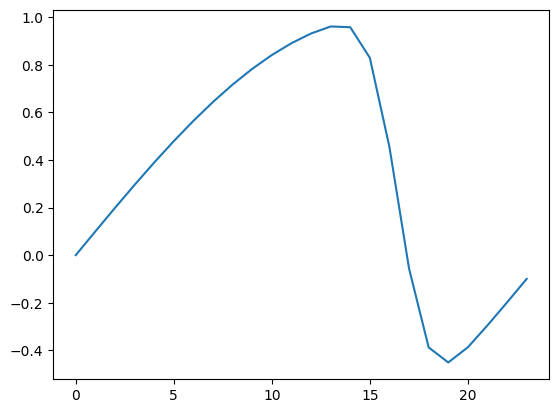

In [29]:
x = np.linspace(0, 1, 11)[:-1] 
psi = np.sin(x)
f  = psi
fl = psi[:nD]
fr = psi[-nD:]
fb = np.concatenate([fl, fr]) 
conti = transform @ fb

plt.plot(np.concatenate([psi, conti]))

In [34]:
N    = 32
Diff = N - 2 * nD
Pb = scipy.linalg.block_diag(Pl, np.identity(Diff), Pr)
Pb

array([[ 0.35355339,  0.35355339,  0.35355339, ...,  0.        ,
         0.        ,  0.        ],
       [-0.54006172, -0.38575837, -0.23145502, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54006172,  0.07715167, -0.23145502, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.36376642,
        -0.49215457,  0.14978617],
       [ 0.        ,  0.        ,  0.        , ...,  0.55391171,
        -0.30772873,  0.06154575],
       [ 0.        ,  0.        ,  0.        , ...,  0.35846409,
        -0.11948803,  0.01706972]])

In [132]:
N = 32
nd = 34
nD = 10

def computeInterpolationMatrix(N, xarray): 
    M = np.zeros((len(xarray), N), dtype=complex)
    for i, x in enumerate(xarray):
        for j in range(N): 
            if j < N/2 + 1:
                kn = j 
            else: 
                kn = j - N 
            #M[i, :] = np.exp(2.j*np.pi*x*N*kn) / N
            M[i, j] = np.exp(2.j*np.pi*x*kn) / N
    return M 

def dfmat(N):
    M = np.zeros((N, N), dtype=complex)
    for i in range(N):
        for j in range(N): 
            M[i, j] = np.exp(-2j * np.pi * i * j / N)

    return M

def idfmat(N):
    M = np.zeros((N, N), dtype=complex)
    for i in range(N):
        for j in range(N): 
            M[i, j] = np.exp(2j * np.pi * i * j / N) / N

    return M

F  = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
Fe = F[:nD, nD:nD + nd - 2]
Fo = F[nD:, nD:nD + nd - 2]
Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD)
Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD)
Pb = np.block([[Pl, np.zeros((nD, nD))], [np.zeros((nD, nD)), Pr]])
mix = np.block([[np.identity(nD) * 0.5, np.identity(nD) * 0.5], [np.identity(nD) * (-0.5), np.identity(nD) * 0.5]])
Fb = np.transpose(np.concatenate([Fe, Fo], axis=0))
transform = Fb @ mix @ Pb 


extendWavefunction = np.block([[np.identity(N)],
                              [np.identity(nD), np.zeros((nD, N - nD))],
                              [np.zeros((nD, N - nD)), np.identity(nD)]]
                              )

computeExtension = np.block([[np.identity(N), np.zeros((N, 2*nD))],
                            [np.zeros((nd - 2, N)), transform]])

computeFFT  = dfmat(computeExtension.shape[0])
computeIFFT = idfmat(computeExtension.shape[0])
Next = N + nd - 2
xend = 1 * ((N - 1) / (Next))
dx   = xend / (N - 1)
xx = np.linspace(0.75 * dx, xend - 0.75 * dx , 2 * (N - 2))
print(xx)
computeInterpolation = computeInterpolationMatrix(Next, xx)
master = computeInterpolation @ computeFFT @ computeExtension @ extendWavefunction



[0.01171875 0.01953125 0.02734375 0.03515625 0.04296875 0.05078125
 0.05859375 0.06640625 0.07421875 0.08203125 0.08984375 0.09765625
 0.10546875 0.11328125 0.12109375 0.12890625 0.13671875 0.14453125
 0.15234375 0.16015625 0.16796875 0.17578125 0.18359375 0.19140625
 0.19921875 0.20703125 0.21484375 0.22265625 0.23046875 0.23828125
 0.24609375 0.25390625 0.26171875 0.26953125 0.27734375 0.28515625
 0.29296875 0.30078125 0.30859375 0.31640625 0.32421875 0.33203125
 0.33984375 0.34765625 0.35546875 0.36328125 0.37109375 0.37890625
 0.38671875 0.39453125 0.40234375 0.41015625 0.41796875 0.42578125
 0.43359375 0.44140625 0.44921875 0.45703125 0.46484375 0.47265625]


In [3]:
import numpy as np
def dfmat(N):
    M = np.zeros((N, N), dtype=complex)
    for i in range(N):
        for j in range(N): 
            M[i, j] = np.exp(-2j * np.pi * i * j / N)

    return M

def idfmat(N):
    M = np.zeros((N, N), dtype=complex)
    for i in range(N):
        for j in range(N): 
            M[i, j] = np.exp(2j * np.pi * i * j / N) / N

    return M

idfmat(5) @ dfmat(5)

array([[ 1.00000000e+00+0.00000000e+00j, -5.06925946e-17-2.82989574e-17j,
        -3.43077782e-18-6.00876543e-17j,  2.43247978e-17-5.37102058e-17j,
         1.03350850e-16-7.16211148e-17j],
       [-5.55111512e-17+0.00000000e+00j,  1.00000000e+00+1.57264342e-17j,
        -4.36462170e-17-1.79538929e-17j,  7.53393892e-18-3.38631560e-17j,
         0.00000000e+00-8.66862588e-17j],
       [-2.77555756e-17+5.55111512e-17j, -5.07153260e-17+1.45495536e-17j,
         1.00000000e+00+5.71902934e-18j, -1.11022302e-16-4.06424922e-17j,
        -2.84398114e-17-6.97595671e-17j],
       [ 2.77555756e-17+5.55111512e-17j,  8.91608738e-18+7.85092079e-17j,
        -1.11022302e-16+4.28879655e-17j,  1.00000000e+00-3.47355611e-18j,
        -5.61310314e-17-2.97966257e-17j],
       [ 1.59594560e-16+1.11022302e-16j,  1.11022302e-16+7.49193927e-17j,
        -1.87074505e-17+5.60915753e-17j, -6.65293220e-17-3.57848204e-18j,
         1.00000000e+00+2.90198749e-18j]])

In [125]:
np.fft.fftfreq(9) * 9

array([ 0.,  1.,  2.,  3.,  4., -4., -3., -2., -1.])

[0.02419355 0.04032258 0.05645161 0.07258065 0.08870968 0.10483871
 0.12096774 0.13709677 0.15322581 0.16935484 0.18548387 0.2016129
 0.21774194 0.23387097 0.25       0.26612903 0.28225806 0.2983871
 0.31451613 0.33064516 0.34677419 0.36290323 0.37903226 0.39516129
 0.41129032 0.42741935 0.44354839 0.45967742 0.47580645 0.49193548
 0.50806452 0.52419355 0.54032258 0.55645161 0.57258065 0.58870968
 0.60483871 0.62096774 0.63709677 0.65322581 0.66935484 0.68548387
 0.7016129  0.71774194 0.73387097 0.75       0.76612903 0.78225806
 0.7983871  0.81451613 0.83064516 0.84677419 0.86290323 0.87903226
 0.89516129 0.91129032 0.92741935 0.94354839 0.95967742 0.97580645]


/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


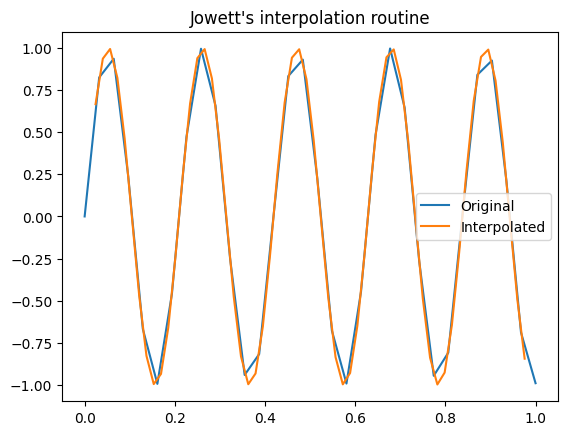

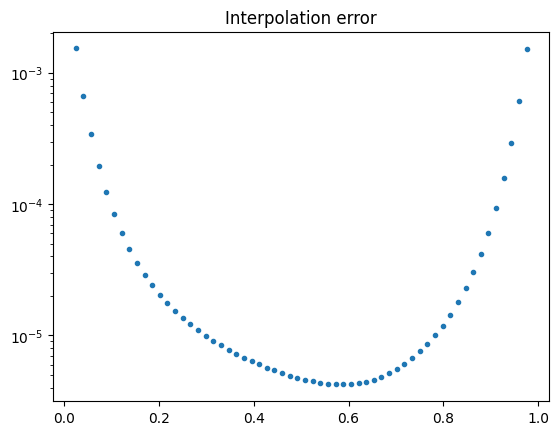

In [133]:


# Generate the x values at which to sample the function
x = np.linspace(0, 1, N)
dx = x[1]-x[0]

def func(x):
    return np.sin(30 * x)
# Evaluate the function at the sample points
y = func(x)

dx = 1/(N - 1) 
xx = np.linspace(0.75 * dx, 1 - 0.75*dx, 2 * (N - 2))
print(xx)
# Compute the FFT of the function
interp = master @ y 

# Print the interpolated value
#print("Interpolated value at x=1.5:", np.real(interp_val))

# Print the interpolated value
plt.title("Jowett's interpolation routine")
plt.plot(x,func(x),'-', label="Original")
plt.plot(xx, interp, label="Interpolated")
plt.legend()
plt.show()

plt.title("Interpolation error")
#plt.plot(x[0]+dx*interp_index,interp_val,'.')
plt.yscale("log")
plt.plot(xx, np.abs(interp-func(xx)),'.')
plt.show()

In [49]:
extend.shape, computeExtension.shape

((48, 32), (46, 48))

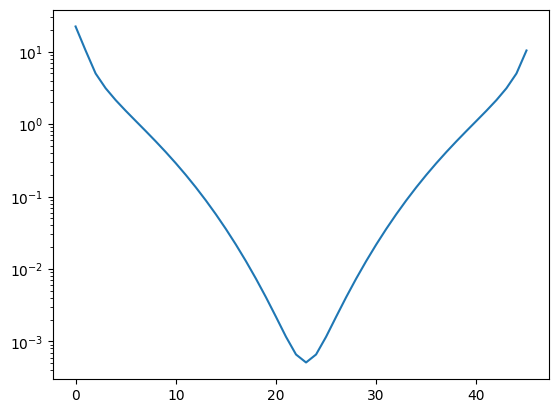

In [38]:
N = 32
Pb = scipy.linalg.block_diag(Pl, np.identity(N - 2 * nD), Pr)
Fb = np.transpose(np.concatenate([Fe, Fo], axis=0))
transform = Fb @ mix @ Pb 

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 32 is different from 16)